### Load accident data corresponding to far_part 121

In [90]:
import pandas as pd
import seaborn as sns
import numpy as np
import random

import collections
import matplotlib.pyplot as plt
%matplotlib inline

## New - With the implementation of eADMS in 2006, the "Events_Sequence" table will replace the "Occurrences"
## table and the "Findings" table will replace the "Seq_of_events" table.

Events_Sequence = pd.read_csv('Events_Sequence.txt', sep = '\t')  ## eADMS coding for accidents after 2006
aircraft = pd.read_excel('aircraft.xlsx')
occurrences = pd.read_csv('Occurrences.txt', sep = ',')
seq_of_events_ = pd.read_csv('seq_of_events.txt', sep = '\t') ## pre eADMS coding for accidents before 2006

narratives = pd.read_excel('narratives.xlsx')
metaData = pd.read_excel('metaData.xlsx')
events = pd.read_excel('events.xlsx')
engines = pd.read_excel('engines.xlsx')
injury = pd.read_excel('injury.xlsx')
findings = pd.read_excel('findings.xlsx')

#### show basic events info

In [92]:
events[events['ev_id']=='20001208X06203']

ev_id     ntsb_no ev_type    ev_date ev_dow  ev_time ev_tmzn  \
985  20001208X06203  DCA96MA068     ACC 1996-07-06     Sa   1424.0     CDT   

       ev_city ev_state ev_country  ... invest_agy  ntsb_docket  \
985  PENSACOLA       FL        USA  ...          N       1696.0   

     ntsb_notf_from ntsb_notf_date ntsb_notf_tm fiche_number  \
985             NaN     1996-07-06          0.0        IMAGE   

                  lchg_date lchg_userid wx_cond_basic faa_dist_office  
985 2019-06-06 16:04:47.680       broda           VMC             NaN  

[1 rows x 71 columns]

#### show event sequences

In [93]:
Events_Sequence[Events_Sequence['ev_id'] == '20001208X08803']

ev_id  Aircraft_Key  Occurrence_No  Occurrence_Code  \
0  20001208X08803             1              3           400240   

                Occurrence_Description  phase_no  eventsoe_no  Defining_ev  \
0  Enroute - Loss of control in flight       400          240            1   

            lchg_date lchg_userid  
0  5/13/2019 14:50:49        bowl

In [94]:
print ('The values of cause_factor are', set(seq_of_events_['Cause_Factor'].values))

The values of cause_factor are {nan, '2', 'D', 'F', 'f', 'X', 'C', '1', ' ', 'c'}


#### Process the values of cause_factor

In [95]:
seq_of_events_[seq_of_events_['Cause_Factor'] == 'X']

ev_id  Aircraft_Key  Occurrence_No  seq_event_no  group_code  \
58266   20001213X34629             1              2             1           2   
76321   20001213X31660             1              1             2           2   
103128  20001214X37504             1              4             1           1   
168019  20001213X33849             1              2             1           2   
197452  20001214X39233             1              2             3           1   
239753  20001211X15049             1              1             2           2   

        Subj_Code Cause_Factor  Modifier_Code  Person_Code  \
58266       24500            X           3131       4000.0   
76321       24539            X           3131       4000.0   
103128      20200            X           2511          0.0   
168019      24551            X           3113       4000.0   
197452      20000            X           2207          0.0   
239753      24551            X           3113       4000.0   

                  lchg_date         lchg_userid  
58266   12/13/2000 16:58:22  dbo                 
76321   12/13/2000 14:40:01  dbo                 
103128  12/14/2000 13:05:05  dbo                 
168019  12/13/2000 16:13:55  dbo                 
197452  12/14/2000 14:24:49  dbo                 
239753  12/11/2000 15:07:06  dbo

In [96]:
seq_of_events = seq_of_events_.dropna(axis = 0, subset =['Cause_Factor']).copy()

In [97]:
seq_of_events.loc[seq_of_events.Cause_Factor == '1','Cause_Factor'] = 'C'
seq_of_events.loc[seq_of_events.Cause_Factor == '2','Cause_Factor'] = 'F'
seq_of_events.loc[seq_of_events.Cause_Factor == 'c','Cause_Factor'] = 'C'
seq_of_events.loc[seq_of_events.Cause_Factor == 'f','Cause_Factor'] = 'F'
seq_of_events.loc[seq_of_events.Cause_Factor == 'D','Cause_Factor'] = 'C'
seq_of_events.loc[seq_of_events.Cause_Factor == 'X','Cause_Factor'] = 'F'

indexes = seq_of_events[seq_of_events['Cause_Factor'] == ' '].index
seq_of_events.drop(indexes, inplace = True)

In [98]:
set(seq_of_events['Cause_Factor'].values)

{'C', 'F'}

In [99]:
metaData['code_iaids'] = metaData['code_iaids'].astype(str)
indices = seq_of_events[seq_of_events['Subj_Code'] == 0].index
seq_of_events.drop(indices, inplace = True)

### Accident Statistical Summary

#### Total number of accidents in far_part 121

In [207]:
ev_ID = aircraft['ev_id'].values.tolist()

## Remove duplicated event IDs
ev_ID = list(set(ev_ID))

print ('There are {} accidents in NTSB database with far_part equal to 121'.format(len(ev_ID)))
print ('The date of the accident data ranges from {} to {}'.format(min(events['ev_year'].values), 
                                                                   max(events['ev_year'].values)))

There are 2243 accidents in NTSB database with far_part equal to 121
The date of the accident data ranges from 1982 to 2019


In [208]:
print ("There are {} accidents from 1982 to 2006".format(len(set(events[events['ev_year'] <= 2006]['ev_id']))))

There are 1742 accidents from 1982 to 2006


#### Basic statistics on personnel injury and aircraft damage

In [215]:
events_part = events[events['ev_id'].isin(ev_ID)]

In [216]:
events_part['ev_highest_injury'].fillna('Not Reported', inplace = True)

In [217]:
from itertools import product
combs = pd.DataFrame(list(product(set(events_part['ev_year'].values), set(events_part['ev_highest_injury'].values))), 
                     columns=['ev_year', 'ev_highest_injury'])

In [218]:
g = events_part.groupby(['ev_year','ev_highest_injury']).size().to_frame('count').reset_index()
g

ev_year ev_highest_injury  count
0       1982              FATL      5
1       1982              MINR      5
2       1982              NONE     27
3       1982              SERS      8
4       1983              FATL      4
..       ...               ...    ...
167     2019              FATL      1
168     2019              MINR      2
169     2019      Not Reported      4
170     2019              SERS      2
171     2019              UNKN      2

[172 rows x 3 columns]

In [219]:
result = g.merge(combs, how = 'right').fillna(0)

In [220]:
FATL_res = result[result['ev_highest_injury'] == 'FATL'].sort_values(by=['ev_year'])
MINR_res = result[result['ev_highest_injury'] == 'MINR'].sort_values(by=['ev_year'])
NONE_res = result[result['ev_highest_injury'] == 'NONE'].sort_values(by=['ev_year'])
SERS_res = result[result['ev_highest_injury'] == 'SERS'].sort_values(by=['ev_year'])
UNKN_res = result[result['ev_highest_injury'] == 'UNKN'].sort_values(by=['ev_year'])
No_Report_res = result[result['ev_highest_injury'] == 'Not Reported'].sort_values(by=['ev_year'])

In [221]:
aircraft['damage'].fillna('Not Reported', inplace = True)

In [222]:
aircraft['ev_year'] = aircraft['ev_id'].astype(str).str[:4]

from itertools import product
aicrftCombs = pd.DataFrame(list(product(set(aircraft['ev_year'].values), set(aircraft['damage'].values))), 
                     columns=['ev_year', 'damage'])

aircraftDamage = aircraft['damage'].groupby([aircraft['ev_year'], aircraft['damage']]).size().to_frame('count').reset_index()

aircraftResult = aircraftDamage.merge(aicrftCombs, how = 'right').fillna(0)

In [223]:
aircraftResult[aircraftResult['ev_year'] == '2015']

ev_year        damage  count
58    2015          MINR    6.0
59    2015          NONE   21.0
60    2015  Not Reported    1.0
61    2015          SUBS    7.0
78    2015          DEST    0.0
79    2015           UNK    0.0

In [224]:
aircraftResult.loc[aircraftResult['ev_year'] == '2000']

ev_year        damage  count
0      2000          DEST   60.0
1      2000          MINR  472.0
2      2000          NONE  532.0
3      2000          SUBS  246.0
4      2000           UNK    1.0
116    2000  Not Reported    0.0

In [225]:
aircraftResult

ev_year        damage  count
0      2000          DEST   60.0
1      2000          MINR  472.0
2      2000          NONE  532.0
3      2000          SUBS  246.0
4      2000           UNK    1.0
..      ...           ...    ...
115    2011  Not Reported    0.0
116    2000  Not Reported    0.0
117    2003           UNK    0.0
118    2003  Not Reported    0.0
119    2019          MINR    0.0

[120 rows x 3 columns]

In [226]:
idx = aircraftResult.index[aircraftResult['ev_year'] == '2000']

aircraftResult.drop(list(idx), inplace = True)

###### Aircraft damage VS year

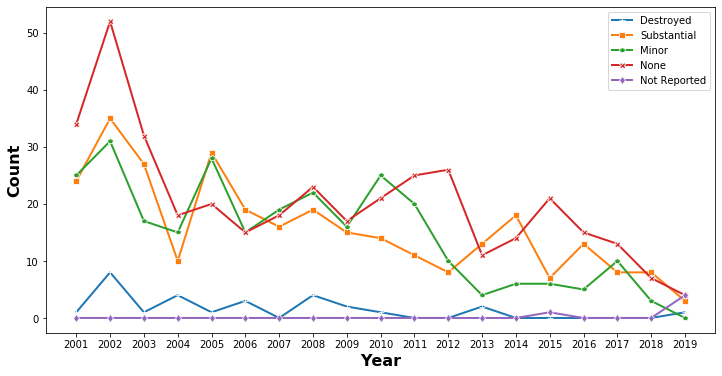

In [227]:
aircraft_DEST_res = aircraftResult[aircraftResult['damage'] == 'DEST'].sort_values(by=['ev_year'])
aircraft_SERS_res = aircraftResult[aircraftResult['damage'] == 'SUBS'].sort_values(by=['ev_year'])
aircraft_MINR_res = aircraftResult[aircraftResult['damage'] == 'MINR'].sort_values(by=['ev_year'])
aircraft_NONE_res = aircraftResult[aircraftResult['damage'] == 'NONE'].sort_values(by=['ev_year'])
aircraft_UNKN_res = aircraftResult[aircraftResult['damage'] == 'Not Reported'].sort_values(by=['ev_year'])

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(aircraft_DEST_res['ev_year'].values, aircraft_DEST_res['count'].values, marker = '+', lw = 2)
sns.lineplot(aircraft_SERS_res['ev_year'].values, aircraft_SERS_res['count'].values, marker = 's', lw = 2)
sns.lineplot(aircraft_MINR_res['ev_year'].values, aircraft_MINR_res['count'].values, marker = 'p', lw = 2)
sns.lineplot(aircraft_NONE_res['ev_year'].values, aircraft_NONE_res['count'].values, marker = 'X', lw = 2)
sns.lineplot(aircraft_UNKN_res['ev_year'].values, aircraft_UNKN_res['count'].values, marker = 'd', lw = 2)
plt.legend(['Destroyed', 'Substantial', 'Minor', 'None', 'Not Reported'])
plt.xlabel('Year', fontsize = 16, fontweight = 'bold')
plt.ylabel('Count', fontsize = 16, fontweight = 'bold')
plt.savefig('damage_vs_year.pdf')

##### Injury VS year

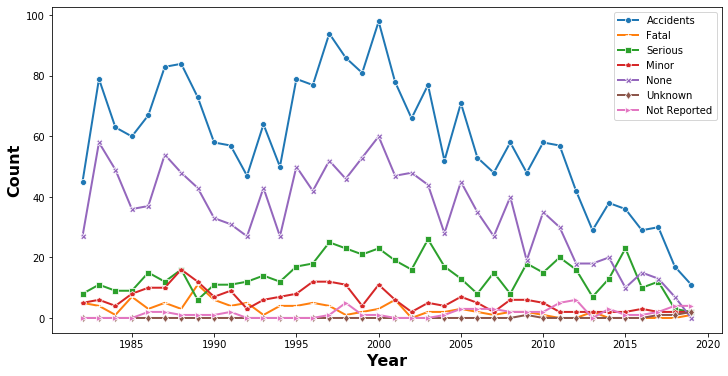

In [228]:
fig, ax = plt.subplots(figsize=(12, 6))

noEventsbyYear = events_part['ev_year'].groupby(events_part['ev_year'].rename('year')).agg({'count'})
sns.lineplot(No_Report_res['ev_year'].values, noEventsbyYear['count'], marker = 'o', lw = 2)

sns.lineplot(FATL_res['ev_year'].values, FATL_res['count'].values, marker = '+', lw = 2)
sns.lineplot(SERS_res['ev_year'].values, SERS_res['count'].values, marker = 's', lw = 2)
sns.lineplot(MINR_res['ev_year'].values, MINR_res['count'].values, marker = 'p', lw = 2)
sns.lineplot(NONE_res['ev_year'].values, NONE_res['count'].values, marker = 'X', lw = 2)
sns.lineplot(UNKN_res['ev_year'].values, UNKN_res['count'].values, marker = 'd', lw = 2)
sns.lineplot(No_Report_res['ev_year'].values, No_Report_res['count'].values, marker = '>', lw = 2)

plt.xlabel('Year', fontsize = 16, fontweight = 'bold')
plt.ylabel('Count', fontsize = 16, fontweight = 'bold')
plt.legend(['Accidents', 'Fatal', 'Serious', 'Minor', 'None', 'Unknown', 'Not Reported'])
plt.savefig('injury_vs_year.pdf')

#### Accident vs Aircraft Manufactuer

In [229]:
acft_make_counter = collections.Counter(aircraft['acft_make'].str.title())
acft_make_counter_plot = {k: v for k, v in acft_make_counter.items() if v > 5}

Text(0, 0.5, 'No of accidents')

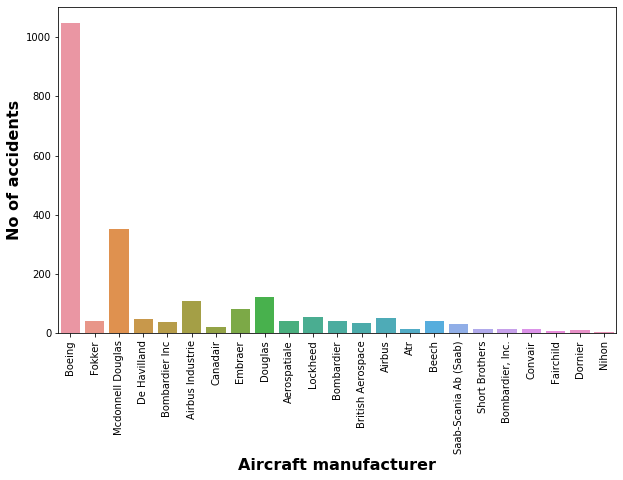

In [230]:
plt.figure(figsize = (10, 6))
sns.barplot(list(acft_make_counter_plot.keys()), list(acft_make_counter_plot.values()))
plt.xticks(rotation=90)
plt.xlabel('Aircraft manufacturer', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of accidents', fontsize = 16, fontweight = 'bold')

#### Accident vs Event Type

In [231]:
ev_type_counter = collections.Counter(events['ev_type'].fillna('Unknown'))
ev_type_keys = ['Accident','Incident','Unknown']

Text(0, 0.5, 'No of events')

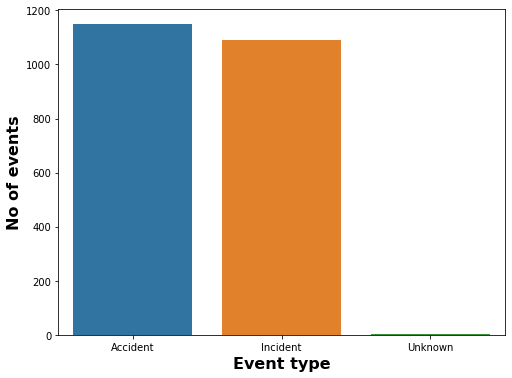

In [232]:
plt.figure(figsize = (8, 6))
sns.barplot(ev_type_keys, list(ev_type_counter.values()))
plt.xlabel('Event type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Year

Text(0, 0.5, 'No of events')

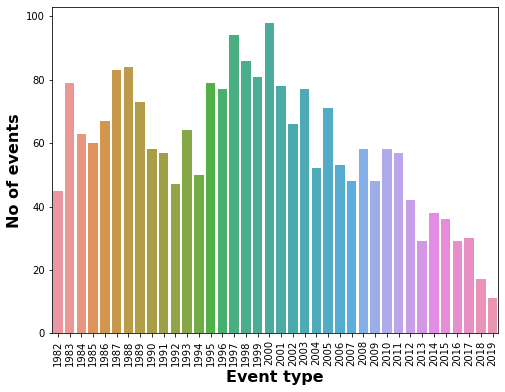

In [233]:
ev_year_counter = collections.Counter(events['ev_year'])

plt.figure(figsize = (8, 6))
sns.barplot(list(ev_year_counter.keys()), list(ev_year_counter.values()))
plt.xticks(rotation=90)
plt.xlabel('Event type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs State

Text(0, 0.5, 'No of events')

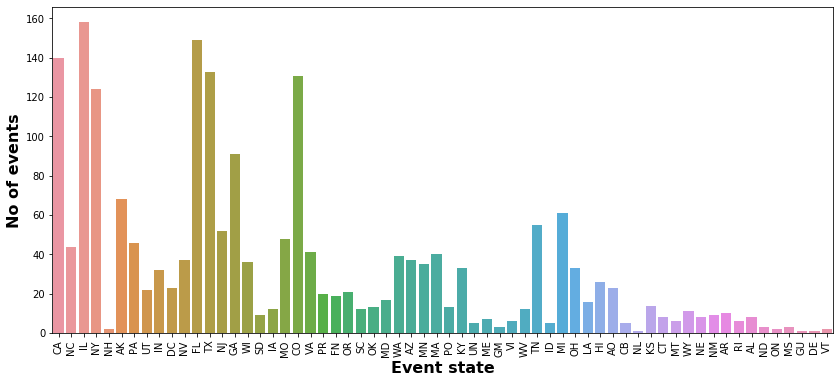

In [234]:
ev_state_counter = collections.Counter(events['ev_state'])

plt.figure(figsize = (14, 6))
sns.barplot(list(ev_state_counter.keys()), list(ev_state_counter.values()))
plt.xticks(rotation=90)
plt.xlabel('Event state', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Wind Gusting

In [235]:
gust_ind_counter = collections.Counter(events['gust_ind'].fillna('Not Reported'))
gust_ind_keys = ['Not Gusting', 'Gusting', 'Unknown', 'Not Reported']

Text(0, 0.5, 'No of events')

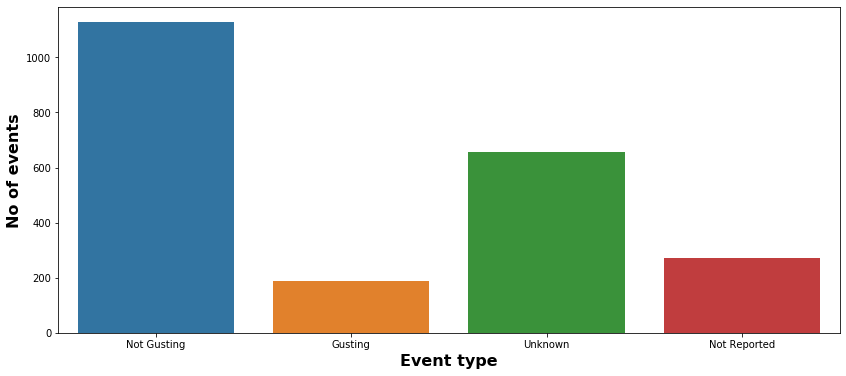

In [236]:
plt.figure(figsize = (14, 6))
sns.barplot(gust_ind_keys, list(gust_ind_counter.values()))
plt.xlabel('Event type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Airport Elevation

In [237]:
elevation = events['apt_elev'].values
elevation = elevation[~np.isnan(elevation)]

Text(0, 0.5, 'Probability')

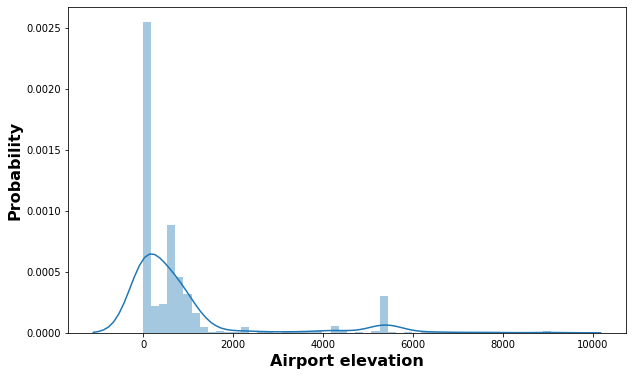

In [238]:
plt.figure(figsize = (10, 6))
sns.distplot(elevation)
plt.xlabel('Airport elevation', fontsize = 16, fontweight = 'bold')
plt.ylabel('Probability', fontsize = 16, fontweight = 'bold')

#### Accident vs Highest Injury

Text(0, 0.5, 'No of events')

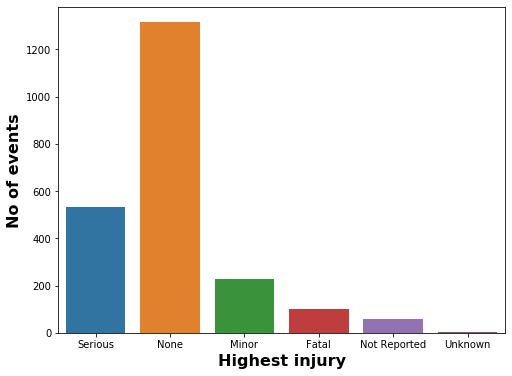

In [239]:
ev_highest_injury_counter = collections.Counter(events['ev_highest_injury'].fillna('Not Reported'))
ev_highest_injury_keys = ['Serious', 'None', 'Minor', 'Fatal', 'Not Reported', 'Unknown']

plt.figure(figsize = (8, 6))
sns.barplot(ev_highest_injury_keys, list(ev_highest_injury_counter.values()))
plt.xlabel('Highest injury', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Aircraft Damage

In [240]:
ev_aircraft_damage_counter = collections.Counter(aircraft['damage'].fillna('Not Reported'))
ev_aircraft_damage_counter

Counter({'NONE': 918,
         'SUBS': 543,
         'MINR': 749,
         'DEST': 88,
         'Not Reported': 5,
         'UNK': 5})

#### Accident vs Location

Text(0, 0.5, 'No of events')

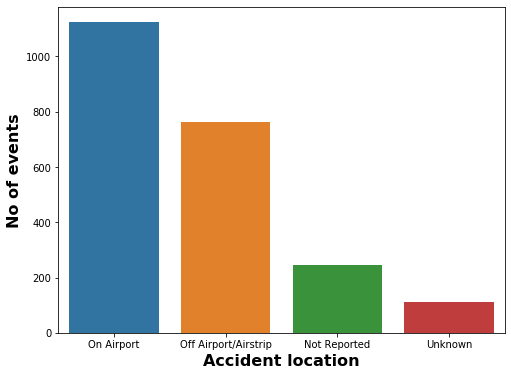

In [241]:
ev_nr_apt_loc_counter = collections.Counter(events['ev_nr_apt_loc'].fillna('Not Reported'))
ev_nr_apt_loc_keys = ['On Airport', 'Off Airport/Airstrip', 'Not Reported', 'Unknown']

plt.figure(figsize = (8, 6))
sns.barplot(ev_nr_apt_loc_keys, list(ev_nr_apt_loc_counter.values()))
plt.xlabel('Accident location', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Light Condition

In [242]:
light_cond_counter = collections.Counter(events['light_cond'].fillna('Unknown'))

light_cond_keys = ['Day','Night/Dark','Night', 'Not Reported', 'Condition-Unknown', 'Dusk', 'Dawn', 'Night//Bright']

Text(0, 0.5, 'No of events')

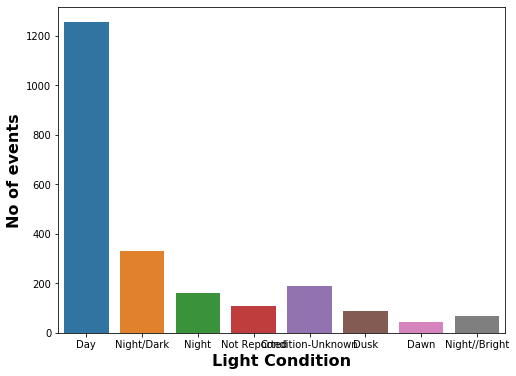

In [243]:
plt.figure(figsize = (8, 6))
sns.barplot(light_cond_keys, list(light_cond_counter.values()))
plt.xlabel('Light Condition', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Engine Type

In [244]:
eng_type_counter = collections.Counter(engines['eng_type'].fillna('Not Reported'))
eng_type_keys = ['Turbo Fan', 'Turbo Prop', 'Unknown', 'Turbo Jet', 'Reciprocating', 'Not Reported', 'Turbo Shaft']

Text(0, 0.5, 'No of events')

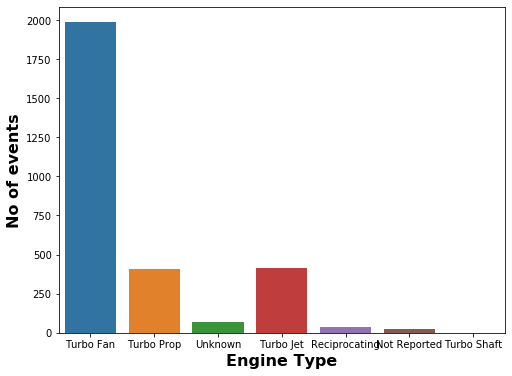

In [245]:
plt.figure(figsize = (8, 6))
sns.barplot(eng_type_keys, list(eng_type_counter.values()))
plt.xlabel('Engine Type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Airframe Hours

Text(0, 0.5, 'Probability')

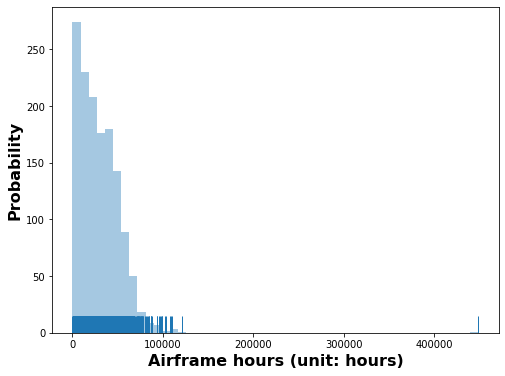

In [246]:
afm_hrs = aircraft['afm_hrs'].values
afm_hrs = afm_hrs[~np.isnan(afm_hrs)]

plt.figure(figsize = (8, 6))
sns.distplot(afm_hrs, kde=False, rug=True)
plt.xlabel('Airframe hours (unit: hours)', fontsize = 16, fontweight = 'bold')
plt.ylabel('Probability', fontsize = 16, fontweight = 'bold')

#### Aircraft Basic Characteristics

In [249]:
aircraft['num_eng']

0       2.0
1       2.0
2       3.0
3       2.0
4       4.0
       ... 
2303    2.0
2304    NaN
2305    2.0
2306    2.0
2307    2.0
Name: num_eng, Length: 2308, dtype: float64

In [136]:
aircraft['oper_pax_cargo']

0        PAX
1       CARG
2       PACA
3       PACA
4       PACA
        ... 
2303     PAX
2304     PAX
2305     PAX
2306     PAX
2307     PAX
Name: oper_pax_cargo, Length: 2308, dtype: object

In [137]:
events['light_cond']

0       DAYL
1       DAYL
2       DAYL
3       DAYL
4       DAYL
        ... 
2238    DAYL
2239      NR
2240    NITE
2241    DAYL
2242    DAYL
Name: light_cond, Length: 2243, dtype: object

In [250]:
import pygraphviz as pgv
from IPython.display import display, Image

def drawImage(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

def drawPDF(dot, fileName):
    return pgv.AGraph(dot).draw(fileName + '.pdf', prog='dot')

##### Derive the consequence of incident as represented by two indicators: personnel injury and aircraft damage

- Four levels of personnel injury: fatal, serious, minor, or none
- Three levels of aircraft damage: destroyed, substantial, minor, or none

In [251]:
import re
def calculate_injury_level(ev_ID):    
    Fatal = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'FATL')]['inj_person_count'].values)
    Serious = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'SERS')]['inj_person_count'].values)
    Minor = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'MINR')]['inj_person_count'].values)
    No = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'NONE')]['inj_person_count'].values)
    Total = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'TOTL')]['inj_person_count'].values)
    
    dict_injury = {}
    if Total != 0:
        dict_injury['Fatal'] = Fatal/Total
        dict_injury['Serious'] = Serious/Total
        dict_injury['Minor'] = Minor/Total
        dict_injury['NONE'] = No/Total
        
        if dict_injury['Fatal'] > 0:
            return 'Fatalinjury'
        elif dict_injury['Serious'] > 0:
            return 'Seriousinjury'
        elif dict_injury['Minor'] > 0:
            return 'Minorinjury'
        else:
            return 'Noinjury'
    else:
        return 'Noinjury'

###### Derive the meaning from code 

In [252]:
def deriveNamebyCode(code):
    try:
        label = metaData[metaData['code_iaids'] == code]['meaning'].values[0]
        name = re.sub('[^a-zA-Z]+', '', label)
    except:
        return 'Unknownquantity', 'Unknown quantity'
    
    return name, label

#### A demo on graphical representation of accident occurrences

In [253]:
sample_ev_ID = '20050627X00874'
#sample_ev_ID = '20001213X29335'
example = narratives[narratives['ev_id'] == sample_ev_ID]

In [254]:
example['narr_accp'].values

array(['HISTORY OF FLIGHT\n\nOn June 7, 2005, at 0125 eastern daylight time, a McDonnell Douglas MD-11F, N250UP, operated by United Parcel Service Company (UPS) as flight 6971, was substantially damaged during landing at the Louisville International Airport-Standiford Field (SDF), Louisville, Kentucky.  There were no injuries to the two flight crewmembers or two passengers.  Night visual meteorological conditions prevailed and an instrument flight rules flight plan had been filed for the flight that originated from the Ted Stevens Anchorage International Airport, Anchorage, Alaska.  The non-scheduled cargo flight was conducted under 14 Code of Federal Regulations Part 121.\n\nAccording to the operator, the airplane experienced a hard landing with a different flight crew during the previous landing in Anchorage.  Postflight inspection of the airplane and landing gear by maintenance personnel did not reveal any abnormalities, and the airplane was released for flight.  In addition, the ac

In [255]:
sample_ev_ID

'20050627X00874'

##### Identify event causes and contributory factors

In [256]:
seq_of_events[seq_of_events['ev_id'] == sample_ev_ID]

ev_id  Aircraft_Key  Occurrence_No  seq_event_no  group_code  \
54944  20050627X00874             1              1             1           2   
54945  20050627X00874             1              1             2           2   

       Subj_Code Cause_Factor  Modifier_Code  Person_Code           lchg_date  \
54944      24627            F           3115       4000.0  2/13/2008 14:12:54   
54945      24500            C           3109       4106.0  2/13/2008 14:12:54   

              lchg_userid  
54944  JOHB                
54945  JOHB

##### Find the event consequences

In [257]:
occurrences[occurrences['ev_id'] == sample_ev_ID]

ev_id  Aircraft_Key  Occurrence_No  Occurrence_Code  \
127663  20050627X00874             1              1              200   

        Phase_of_Flight  Altitude           lchg_date         lchg_userid  
127663              570         0  2/13/2008 14:12:54  JOHB

##### Create functions to build the network consisting of nodes and edges

In [258]:
dictEdges = {}

lst = ['eventId', 'from', 'to']
df_records = pd.DataFrame(columns=lst)

def addEdges(key, ev_ID):
    if key in dictEdges.keys():
        dictEdges[key] += 1
    else:
        dictEdges[key] = 1
    
    global df_records
    fromNode, toNode = key.split('->')
    row = {'eventId': ev_ID, 'from': fromNode, 'to': toNode}
    df_records = df_records.append(row, ignore_index=True)
    
    
dictNodeLabel = {}
def addNodeLabel(key, value):
    if key == 'Flightcrew':
        dictNodeLabel[key] = 'Flight crew'
        return
    if key not in dictNodeLabel.keys():
        dictNodeLabel[key] = value
        
dictNodeLabel['Fatalinjury'] = 'Fatal injury'
dictNodeLabel['Seriousinjury'] = 'Serious injury'
dictNodeLabel['Minorinjury'] = 'Minor injury'
dictNodeLabel['Noinjury'] = 'No injury'
dictNodeLabel['Unknownreason'] = 'Unknown reason'

#### Build graphical representations for the escalation of initiating events

In [262]:
def buildOneGraphRep(sample_ev_ID):

    g1 = "digraph top {"
    g1 += """size ="12,12"; """
    g1 += "graph [compound=true];"
    
    # Query the year that the accident happened
    ev_year = events[events['ev_id'] == sample_ev_ID]['ev_year'].values[0]
    
    if ev_year <= 2006:
        eventSequences = seq_of_events[seq_of_events['ev_id'] == sample_ev_ID][['Occurrence_No', 'seq_event_no', 
                                                                  'Subj_Code', 'Modifier_Code', 'Person_Code']]

        ## Construct the subject name
        subjectList = []
        for index, row in eventSequences.iterrows():
            Subj_Code = str(int(row['Subj_Code']))
            Modifier_Code = str(int(row['Modifier_Code']))
            Person_Code = str(int(row['Person_Code']))
            Occurrence_No = int(row['Occurrence_No'])

            subjectName, subjectLabel = deriveNamebyCode(Subj_Code)
            #print (subjectName, subjectLabel)
            
            if Modifier_Code != '0':
                modifierName, modifierLabel = deriveNamebyCode(Modifier_Code)
                
                if len(modifierName) > 0:
                    subjectName = subjectName #+ modifierName
                    subjectLabel = subjectLabel #+ ':' + modifierLabel

            g1 += subjectName + ' [label =' + '"' + subjectLabel + '"'+ '];'
            subjectList.append([Occurrence_No, subjectName])
            addNodeLabel(subjectName, subjectLabel)

            if Person_Code != '0':
                personName, personeLabel = deriveNamebyCode(Person_Code)
                g1 += personName + '[label = ' + '"' + personeLabel + '"' + '];'
                g1 += personName + '->' + subjectName + ';'
                addEdges(personName + '->' + subjectName, sample_ev_ID)
                addNodeLabel(personName, personeLabel)

        ## construct sequence of occurrence
        eventOccurrences = occurrences[occurrences['ev_id'] == sample_ev_ID][['Occurrence_Code', 'Phase_of_Flight']]
        occurrenceCount = 0
        OccurrenceName = ''
        
        for index, row in eventOccurrences.iterrows():
            Occurrence_Code = str(row['Occurrence_Code'])
            Phase_of_Flight = str(row['Phase_of_Flight'])

            prevOccurrence = OccurrenceName
            OccurrenceName, OccurrenceLabel  = deriveNamebyCode(Occurrence_Code)
            flightPhaseName, flightPhaseLabel = deriveNamebyCode(Phase_of_Flight)

            g1 += OccurrenceName + ' [label = ' + '"' + OccurrenceLabel + '"' + ', style=filled, color=".2 .5 0.9"];'
            addNodeLabel(OccurrenceName, OccurrenceLabel)
            addNodeLabel(flightPhaseName, flightPhaseLabel)
            
            for subject in subjectList:
                if subject[0] == occurrenceCount + 1:
                    connection = subject[1] + '->' + OccurrenceName + ';'
                    if connection not in g1:
                        g1 += subject[1] + '->' + OccurrenceName + ';'
                        addEdges(subject[1] + '->' + OccurrenceName, sample_ev_ID)
            
            if occurrenceCount == 0:
                #g1 += flightPhaseName + ' [label = ' + '"' + flightPhaseLabel + '"' + '];'
                #g1 += flightPhaseName + '->' + OccurrenceName + ';'
                #addEdges(flightPhaseName + '->' + OccurrenceName)
                pass
            
            if occurrenceCount >= 1:
                g1 += prevOccurrence + '->' + OccurrenceName + ';'
                #g1 += flightPhaseName + ' [label = ' + '"' + flightPhaseLabel + '"' + '];'
                #g1 += flightPhaseName + '->' + OccurrenceName + ';'
                
                addEdges(prevOccurrence + '->' + OccurrenceName, sample_ev_ID)
                #addEdges(flightPhaseName + '->' + OccurrenceName)

            occurrenceCount += 1

        ## Outcome of accident
        aircraftDamageLevel = aircraft[aircraft['ev_id'] == sample_ev_ID]['damage'].values[0]
        aircraftDamageName = dictAircraftDamage[aircraftDamageLevel] + 'aircraftdamage'
        aircraftDamageLabel = dictAircraftDamage[aircraftDamageLevel] + ' aircraft damage'
        addNodeLabel(aircraftDamageName, aircraftDamageLabel)
        
        g1 += aircraftDamageName + '[label = ' + '"'+ aircraftDamageLabel + '"' +', style=filled];'
        
        if OccurrenceName == '':
            OccurrenceName = 'Unknownreason'
            
        g1 += OccurrenceName + '->' + aircraftDamageName + ';'
        addEdges(OccurrenceName + '->' + aircraftDamageName, sample_ev_ID)

        injuryLevel = calculate_injury_level(sample_ev_ID)
        
        g1 += injuryLevel + '[label = ' + '"'+ dictNodeLabel[injuryLevel] + '"' +', style=filled];'
        g1 += OccurrenceName + '->' + injuryLevel + ';'
        addEdges(OccurrenceName + '->' + injuryLevel, sample_ev_ID)

        g1 += "}"
        
        return g1

#### Demo of graphical representation

In [263]:
sample_ev_ID

'20050627X00874'

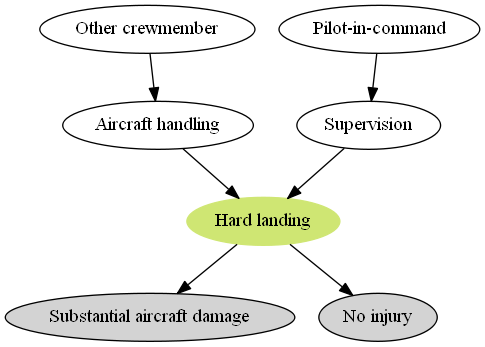

In [264]:
dictAircraftDamage = {'MINR': 'Minor', 'DEST': 'Destroyed', 'NONE': 'None', 'UNK': 'Unknown', 'SUBS': 'Substantial'}
dictEdges = {}
g1 = buildOneGraphRep(sample_ev_ID)
drawImage(g1)

#### Build the connections for all the accidents that happened before 2006

In [265]:
df_records.drop(df_records.index, inplace=True)
dictEdges = {}

for sample_ev_ID in ev_ID:
    buildOneGraphRep(sample_ev_ID)

In [266]:
setCauses = set(df_records['from'].values)

dictElement = {}

for cause in setCauses:
    outcomes = set(df_records[(df_records['from'] == cause)]['to'].values)
    
    for outcome in outcomes:
        #print ('no causes: ', no_causes)

        key = cause + '->' + outcome

        jointEvents = set(df_records[(df_records['to'] == outcome) & (df_records['from'] == cause)]['eventId'].values)
        denominator = set(df_records[(df_records['from'] == cause) | (df_records['to'] == cause)]['eventId'].values)

        if key not in dictElement.keys():
            dictElement[key] = len(jointEvents)/len(denominator)
            
            if dictElement[key] == 1:
                dictElement[key] = dictElement[key] * 0.95

In [267]:
len(dictElement)

3158

In [268]:
len(dictEdges)

3158

#### Construct a dataframe to represent all the links in the network

In [269]:
lst = ['name', 'fromID', 'toID', 'count']
df_edges = pd.DataFrame(columns = lst)

for key, value in dictEdges.items():
    name = key
    fromID, toID = str(key).split('->')
    count = dictElement[key]
    
    row = {'name': key, 'fromID': fromID, 'toID': toID, 'count': count}
    df_edges = df_edges.append(row, ignore_index=True)

In [270]:
df_records[df_records['to'] == 'Inflightencounterwithweather']

eventId                       from                            to
30     20001207X03768           Weathercondition  Inflightencounterwithweather
31     20001207X03768                   Seatbelt  Inflightencounterwithweather
132    20001213X32573             Lightcondition  Inflightencounterwithweather
133    20001213X32573           Weathercondition  Inflightencounterwithweather
192    20001212X16941           Weathercondition  Inflightencounterwithweather
...               ...                        ...                           ...
11095  20001208X07667           Weathercondition  Inflightencounterwithweather
11096  20001208X07667      Crewgroupcoordination  Inflightencounterwithweather
11156  20001211X10090           Weathercondition  Inflightencounterwithweather
11157  20001211X10090   Flightintoadverseweather  Inflightencounterwithweather
11234  20001213X34548  Instructionswrittenverbal  Inflightencounterwithweather

[417 rows x 3 columns]

In [271]:
parentInfo = df_edges[df_edges['toID'] == 'Inflightencounterwithweather'][['fromID', 'count']].values
sorted(parentInfo, key=lambda x: x[1], reverse = True)

[array(['Weatherradar', 0.95], dtype=object),
 array(['Inflightweatheradvisories', 0.95], dtype=object),
 array(['Meteorologicalservice', 0.95], dtype=object),
 array(['Preflightbriefingservice', 0.95], dtype=object),
 array(['Flightnavigationinstrumentsairspeedindicator', 0.95], dtype=object),
 array(['Weatherforecast', 0.95], dtype=object),
 array(['Miscellaneousequipmentfurnishingsfirstaidequipment', 0.95],
       dtype=object),
 array(['Flightcontrolelevatorsurface', 0.95], dtype=object),
 array(['Pressure', 0.95], dtype=object),
 array(['Flightintoadverseweather', 0.9230769230769231], dtype=object),
 array(['Seatbeltsign', 0.8571428571428571], dtype=object),
 array(['Passengerbriefing', 0.8333333333333334], dtype=object),
 array(['Hazardousweatheradvisory', 0.8333333333333334], dtype=object),
 array(['Seatbelt', 0.8292682926829268], dtype=object),
 array(['Flightintoknownadverseweather', 0.6666666666666666], dtype=object),
 array(['Crewgroupbriefing', 0.625], dtype=object),
 array

### Construct Bayesian network with PySMILE library

#### Construct XDSL file to be fed into PySMILE

In [272]:
import numpy as np
from scipy.optimize import minimize
import scipy.stats

def obj(x, normProb, probs):
    diff = (1 + np.exp(x[0]+x[1]))/(1 + np.exp(x[0]/normProb + x[1])) - probs
    return np.sum(diff**2)

def obj_beta(x, normProb, probs):
    pred = []
    for i in normProb:
        beta = scipy.stats.beta.cdf(i, a = x[0], b = x[1])
        #print (beta)
        pred.append(beta)
            
    #print (scipy.stats.beta.cdf(normProb, a = 1, b = 1))
    #diff = scipy.stats.beta.cdf(normProb, a = x[0], b = x[1]) - probs
    diff = pred - probs
    return np.mean(diff**2)

def CPT_estimation(x, a, b):
    return scipy.stats.beta.cdf(x, a = a, b = b)

In [273]:
def binaryConversion(value, n):
    m = eval('"' + "{0:0" + str(n) + "b}" + '"').format(value) ## binary representation
    characters = [int(char) for char in str(m)]
    res = np.array(characters)
    return res

In [306]:
dictParameter = {}

def constructCPT(parentInfo, toID):
    n = parentInfo.shape[0]
    count = parentInfo[:, 1]

    start = 2**n - 1
    
    CPT = []
    lambda_val = sum(count) - 1
    squared_error = []
    for i in range(start, -1, -1):
        scheme = binaryConversion(i, n)
        
        if sum(scheme) == 1 or sum(scheme) == 0:
            Yes_prob = np.sum(np.multiply(scheme, count))
        else:
            totalContribution = np.sum(count)
            normContribution = count/totalContribution
            
            #normContribution = np.array([min(normContribution), max(normContribution)])
            #probs = np.array([min(count), max(count)])
            
            normContribution = np.array(normContribution)
            probs = np.array(count)
            
            if toID not in dictParameter.keys():
                ## calibrate the parameters
                x_0 = [2, 1]
                
                #res = minimize(obj, x_0, args = (normContribution, probs), method='Powell', tol=1e-6)
                res = minimize(obj_beta, x_0, args = (normContribution, probs), method='Nelder-Mead', tol=1e-7)

                a = res.x[0]
                b = res.x[1]
                
                dictParameter[toID] = [a, b]
                
                #print ('Obj: ', res.fun, 'a:', a, 'b: ', b)
                squared_error.append(res.fun)
            else:
                a = dictParameter[toID][0]
                b = dictParameter[toID][1]
            
            CPT_contribution = np.sum(np.multiply(scheme, count))/totalContribution
            Yes_prob = CPT_estimation(CPT_contribution, a, b)
            
            if Yes_prob < max(np.multiply(scheme, count)):
                Yes_prob = max(np.multiply(scheme, count))
                
            #print (Yes_prob, max(np.multiply(scheme, count)))
            
            assert Yes_prob >= max(np.multiply(scheme, count))
            
        No_prob = 1 - Yes_prob
        
        CPT.append(Yes_prob)
        CPT.append(No_prob)
    
    return CPT, squared_error

def occurrenceTimes(toID):
    toID = set(df_records[df_records['to'] == toID]['eventId'].values)
    fromID = set(df_records[df_records['from'] == toID]['eventId'].values)
    return len(toID.union(fromID))

def occurrenceTimesFromID(fromID):
    return len(set(df_records[df_records['from'] == fromID]['eventId'].values))

In [165]:
#parentInfo = df_edges[df_edges['toID'] == 'Fire'][['fromID', 'count']].values
#constructCPT(parentInfo, 'Fire')

##### Define the denominator to represent the number of flights from 1982 to 2006

In [277]:
maxElements = 12

def searchThreshold(parentInfo):
    threshold = 0
    
    m = len(np.where(parentInfo[:, 1] > threshold)[0])
    
    while m > maxElements:
        if m < maxElements:
            threshold -= min(parentInfo[:, 1])
        else:
            threshold += min(parentInfo[:, 1])
   
        m = len(np.where(parentInfo[:, 1] > threshold)[0])
    
    if threshold > max(parentInfo[:, 1]):
        threshold = max(parentInfo[:, 1])
    
    return threshold

###### Compute the total number of scheduled flights within USA

In [278]:
departures = pd.read_excel('table_01_37_061019.xlsx')
departures.drop(departures.columns[0], axis=1, inplace= True)

In [279]:
years = departures.iloc[0].index
flights = departures.iloc[0].values

In [280]:
flights

array([ 4555516.,  5156848.,  5505659.,  6641681.,  6545000.,  6606609.,
        7193841.,  7513232.,  8030530.,  8204674.,  8095888.,  8248269.,
        8605486.,  8929559.,  8548932.,  8052756.,  8585736.,  9444234.,
        9859941.,  9512017., 10985488., 10307025.,  9646132.,  9596396.,
        9577700.,  9345013.,  9217652.,  8986825.,  8965387.,  9276526.,
        9305375.,  9559858.])

In [281]:
years = [int(i) for i in years]

Text(0, 0.5, 'Scheduled flights')

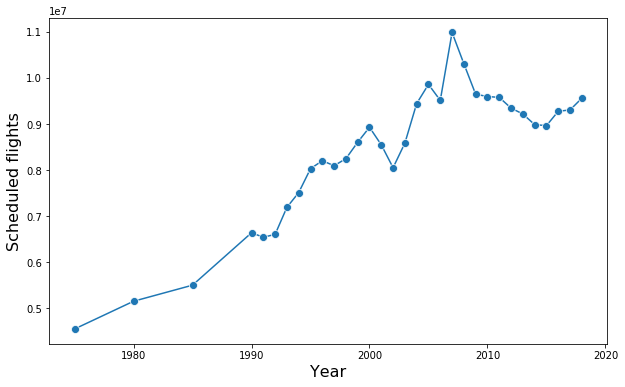

In [282]:
plt.figure(figsize=(10, 6))
sns.lineplot(years, flights, marker = 'o', markersize = 8)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Scheduled flights', fontsize = 16)

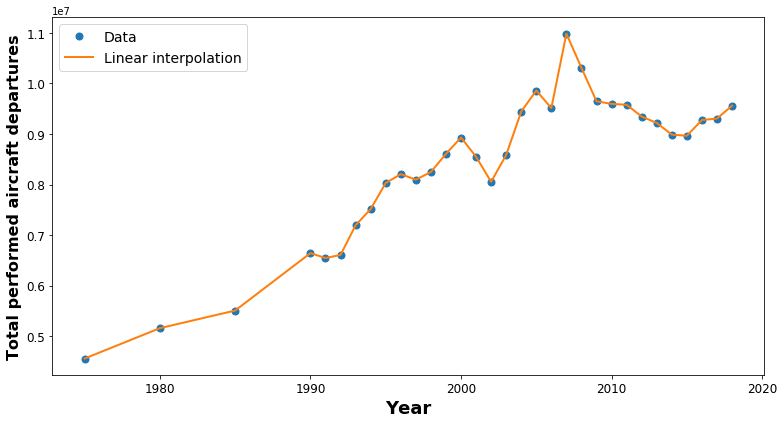

In [283]:
from scipy.interpolate import interp1d

f = interp1d(years, flights)
xnew = np.linspace(1975, 2018, num = 44, endpoint=True)

fig, ax = plt.subplots(figsize=(11, 6))
plt.plot(years, flights, 'o', xnew, f(xnew), '-', markersize = 7, linewidth=2)
plt.legend(['Data', 'Linear interpolation'], loc='best', fontsize = 14)
plt.xlabel('Year', fontsize = 18, fontweight = 'bold')
plt.ylabel('Total performed aircraft departures', fontsize = 16, fontweight = 'bold')
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()

plt.savefig('departures.pdf')

In [284]:
totalFlights = 0
for i in range(1982, 2007, 1):
    totalFlights += f(i)

In [285]:
totalFlights = round(totalFlights)
print ('The total number of flights from 1982 to 2006 is', totalFlights)

The total number of flights from 1982 to 2006 is 184517128.0


##### Prior probability estimation

In [287]:
event = 'Fire'

In [288]:
eventID_list = set(df_records[(df_records['from'] == event) | (df_records['to'] == event)]['eventId'].values)
totalOccurrences = len(eventID_list)
prob_yes = totalOccurrences/totalFlights
prob_no = 1 - prob_yes
print ('Total occurrences of event %s: %d' % (event, totalOccurrences))
print ('Prior probability of fire occurrence is: ', prob_yes)

Total occurrences of event Fire: 102
Prior probability of fire occurrence is:  5.527942099770814e-07


In [289]:
df_records[df_records['eventId'] == '20050209X00169']

eventId                  from                  to
8926  20050209X00169            Flightcrew       Visuallookout
8927  20050209X00169      Airportpersonnel             Airport
8928  20050209X00169  FAAotherorganization             Airport
8929  20050209X00169         Visuallookout  Miscellaneousother
8930  20050209X00169               Airport  Miscellaneousother
8931  20050209X00169    Miscellaneousother  Noneaircraftdamage
8932  20050209X00169    Miscellaneousother            Noinjury

##### Conditional probability estimation

In [290]:
causes = set(df_records[df_records['to'] == event]['from'].values)

total = 0
maxOccurrence = -1
prob_set = []
for cause in causes:
    cause_occurrences = len(set(df_records[(df_records['from'] == cause) & (df_records['to'] == event)]['eventId'].values))
    
    #print ('Cause: ', dictNodeLabel[cause], ', Occurrence: ', cause_occurrences, ', Prob: ',
    # cause_occurrences/totalOccurrences)
    
    total += cause_occurrences/totalOccurrences
    prob_set.append(cause_occurrences/totalOccurrences)
    
    
    if cause_occurrences > maxOccurrence:
        maxOccurrence = cause_occurrences
        
print ('The maximum number of occurrence is', maxOccurrence)

The maximum number of occurrence is 32


In [291]:
set(prob_set)

{0.00980392156862745,
 0.0196078431372549,
 0.029411764705882353,
 0.0392156862745098,
 0.049019607843137254,
 0.058823529411764705,
 0.08823529411764706,
 0.3137254901960784}

In [292]:
total

1.735294117647057

In [293]:
conditional_prob = maxOccurrence/totalOccurrences

In [294]:
totalOccurrences

102

In [295]:
conditional_prob

0.3137254901960784

##### Generate BN

In [298]:
noFlights = totalFlights

##### Remove cycles in the Bayesian network

In [299]:
cyclesRows = df_edges[df_edges['fromID'] == df_edges['toID']]

In [300]:
df_edges.drop(cyclesRows.index, inplace = True)

In [301]:
for i in cyclesRows['fromID']:
    dictEdges.pop(str(i) + '->' + str(i))

In [324]:
XDSL = """<?xml version="1.0" encoding="ISO-8859-1"?>
<!-- This network was created in GeNIe Academic, which can be used for educational and research purposes only -->
<smile version="1.0" id="Network1" numsamples="99999999" discsamples="99999999"> """

nodeConstructor = "\n\t<nodes>"
extensions = '\n\t<extensions>'
extensions += """\n\t\t<genie version="1.0" app="GeNIe 2.4.4420.0 ACADEMIC" name="Network1" faultnameformat="nodestate">"""

networkNodes = set([])
allNodeNames = []

## add parent nodes
for key, value in dictEdges.items():
    fromID, toID = key.split('->')
    
    allNodeNames.append(fromID)
    allNodeNames.append(toID)
    
    parentInfo = df_edges[df_edges['toID'] == fromID][['fromID', 'count']].values
        
    if fromID not in networkNodes and len(parentInfo) == 0: ## if the node has no parents, add it first
        #print ('... ', fromID)

        ## compute prior probabilities
        Yes_prob = occurrenceTimesFromID(fromID)/noFlights
        No_prob = 1 - Yes_prob

        ## construct parent nodes
        nodeConstructor += "\n\t\t<cpt id=" + '"' + fromID + '"' + """>"""
        nodeConstructor += """\n\t\t\t<state id="Yes" />\n\t\t\t<state id="No" />"""
        nodeConstructor += "\n\t\t\t<probabilities>" + str(Yes_prob) + " " +  str(No_prob) + "</probabilities>"
        nodeConstructor += '\n\t\t</cpt>'

        ## add extensions for parent nodes
        extensions += "\n\t\t\t<node id=" +  '"' + fromID + '"' + ">"
        extensions += "\n\t\t\t\t<name>" + dictNodeLabel[fromID] + "</name>"
        extensions += """\n\t\t\t\t<interior color="e5f6f7" />"""
        extensions += """\n\t\t\t\t<outline color="000080" />"""
        extensions += """\n\t\t\t\t<font color="000000" name="Arial" size="8" />"""
        extensions += "\n\t\t\t\t<position> 250 160 426 251 </position>"
        extensions += """\n\t\t\t\t<barchart active="true" width="258" height="64" />"""
        extensions += "\n\t\t\t</node>"

        networkNodes.add(fromID)

allNodeNames = set(allNodeNames)

error = []
while len(networkNodes) < len(allNodeNames):
    
    ## add child nodes
    for key, value in dictEdges.items():
        fromID, toID = key.split('->')

        parentInfo = df_edges[df_edges['toID'] == toID][['fromID', 'count']].values

        indexMaxValues = np.where(parentInfo[:, 1] == max(parentInfo[:, 1]))[0]
        noMaxValues = len(indexMaxValues)

        if noMaxValues > maxElements:
            ## inject jitter to the maxvalue
            jitter = [random.random() for i in range(noMaxValues)] 
            jitter = np.array(jitter) * min(parentInfo[:, 1])
            parentInfo[indexMaxValues, 1] = parentInfo[indexMaxValues, 1] + jitter

        n = parentInfo.shape[0]

        if n > maxElements:
            delta = searchThreshold(parentInfo)
            parentInfo = parentInfo[np.where(parentInfo[:, 1] >= delta), :][0]

        parentNodeNames = list(parentInfo[:, 0])
        
        
        if toID not in networkNodes and set(parentNodeNames).issubset(set(networkNodes)):
            
            #print ('yes----->')

            ## build conditional probability table
            CPT, obj = constructCPT(parentInfo, toID)
            error.append(obj)

            CPT_str = list(map(str, CPT))

            childDesp = "\n\t\t<cpt id=" + '"' + str(toID) + '"' + """>"""
            childDesp += """\n\t\t\t<state id="Yes" />\n\t\t\t<state id="No" />"""
            childDesp += "\n\t\t\t<parents>" + ' '.join(parentNodeNames) + "</parents>"
            childDesp += "\n\t\t\t<probabilities>"+ ' '.join(CPT_str)+"</probabilities>"
            childDesp += "\n\t\t</cpt>"

            nodeConstructor += childDesp
            networkNodes.add(toID)
            
            #print (len(networkNodes))

            ## add child node
            extensions += "\n\t\t\t<node id=" +  '"' + toID + '"' + ">"
            extensions += "\n\t\t\t\t<name>" + dictNodeLabel[toID] + "</name>"
            extensions += """\n\t\t\t\t<interior color="e5f6f7" />"""
            extensions += """\n\t\t\t\t<outline color="000080" />"""
            extensions += """\n\t\t\t\t<font color="000000" name="Arial" size="8" />"""
            extensions += "\n\t\t\t\t<position> 250 160 426 251 </position>"
            extensions += """\n\t\t\t\t<barchart active="true" width="258" height="64" />"""
            extensions += "\n\t\t\t</node>"
            
nodeConstructor += "\n\t</nodes>"
extensions += '\n\t\t</genie>'
extensions += '\n\t</extensions>'

In [325]:
error = [ele for ele in error if ele != []]
error = sum(error, [])

In [326]:
print ('The average mean squared error of all predictions is {}, and the standard deviation is {}'.\
       format(np.mean(error), np.std(error)))

The average mean squared error of all predictions is 2.8120933216734857e-10, and the standard deviation is 0.0


In [327]:
set(allNodeNames) - set(networkNodes)

set()

In [328]:
df_edges[df_edges['toID'] == 'Propellerblastorjetexhaustsuction']['fromID'].values

array(['Miscellaneousequipmentfurnishingswheelchocks',
       'Proceduresdirectives', 'Planningdecision',
       'Unsafehazardouscondition', 'Lackoftotalexperienceintypeoperation',
       'Object', 'Clearance', 'Identificationofaircraftvisually',
       'Inadequatetraining', 'Procedureinadequate',
       'Airportfacilitiestaxiwaycondition', 'Aircrafthandling',
       'Visuallookout'], dtype=object)

In [329]:
df_edges[df_edges['toID'] == 'Propellerblastorjetexhaustsuction']

name  \
168   Miscellaneousequipmentfurnishingswheelchocks->...   
169   Proceduresdirectives->Propellerblastorjetexhau...   
386   Planningdecision->Propellerblastorjetexhaustsu...   
670   Unsafehazardouscondition->Propellerblastorjete...   
1552  Lackoftotalexperienceintypeoperation->Propelle...   
1602          Object->Propellerblastorjetexhaustsuction   
1603       Clearance->Propellerblastorjetexhaustsuction   
1604  Identificationofaircraftvisually->Propellerbla...   
1955  Inadequatetraining->Propellerblastorjetexhaust...   
1956  Procedureinadequate->Propellerblastorjetexhaus...   
2868  Airportfacilitiestaxiwaycondition->Propellerbl...   
2869  Aircrafthandling->Propellerblastorjetexhaustsu...   
2947   Visuallookout->Propellerblastorjetexhaustsuction   

                                            fromID  \
168   Miscellaneousequipmentfurnishingswheelchocks   
169                           Proceduresdirectives   
386                               Planningdecision   
670                       Unsafehazardouscondition   
1552          Lackoftotalexperienceintypeoperation   
1602                                        Object   
1603                                     Clearance   
1604              Identificationofaircraftvisually   
1955                            Inadequatetraining   
1956                           Procedureinadequate   
2868             Airportfacilitiestaxiwaycondition   
2869                              Aircrafthandling   
2947                                 Visuallookout   

                                   toID     count  
168   Propellerblastorjetexhaustsuction  0.500000  
169   Propellerblastorjetexhaustsuction  0.027586  
386   Propellerblastorjetexhaustsuction  0.153846  
670   Propellerblastorjetexhaustsuction  0.052632  
1552  Propellerblastorjetexhaustsuction  0.333333  
1602  Propellerblastorjetexhaustsuction  0.021277  
1603  Propellerblastorjetexhaustsuction  0.022727  
1604  Propellerblastorjetexhaustsuction  0.125000  
1955  Propellerblastorjetexhaustsuction  0.090909  
1956  Propellerblastorjetexhaustsuction  0.019231  
2868  Propellerblastorjetexhaustsuction  0.111111  
2869  Propellerblastorjetexhaustsuction  0.038462  
2947  Propellerblastorjetexhaustsuction  0.014706

In [330]:
len(dictEdges)

3146

In [331]:
len(networkNodes)

740

In [332]:
XDSL += nodeConstructor
XDSL += extensions
XDSL += '\n</smile>'

In [333]:
### Write XDSL to file
file = open("NTSB.xdsl","w")
file.write(XDSL)

#print (XDSL)

5695978